In [31]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set default to run on the GPU if available (for the speed up)
if torch.cuda.is_available():
    torch.cuda.set_device(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [32]:
# Creating a custom dataset
from io import open
import glob
import os
from torch.utils.data import Dataset, DataLoader, random_split
import unicodedata
import string
import numpy as np


all_letters = string.ascii_letters + " .,;'"  "0" #We add 0 to pad the sequences 
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
def findFiles(path): return glob.glob(path)

def letterToIndex(letter):
    return all_letters.find(letter)

def nameToTensor(name):
    tensor = torch.zeros(len(name), n_letters)
    count = 0
    for li, letter in enumerate(name):
        tensor[li][letterToIndex(letter)] = 1
    return tensor


def categorie_to_tensor(index, num_categories):
    t = torch.zeros(num_categories, dtype=torch.long)
    t[index] = 1.0
    return t

class NameDataset(Dataset):
    
    '''
    Datasets needs an __init__, __get_item__ and __len__
    '''
    def __init__(self, data_root, to_tensors=True,):
        self.samples = []
        self.all_categories = []
        
        for filename in findFiles('names/*.txt'):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.all_categories.append(category)
            lines = readLines(filename)
            for line in lines:
                self.samples.append((line, category))
        
        self.num_categories = len(self.all_categories)
        
    
        #pad the sequences
        self.pad_sequences()
        
        if to_tensors:
            self.samples = [(nameToTensor(name), self.all_categories.index(language) ) for name, language in self.samples]


    def pad_sequences(self):
        
        #We want to pad the sequence
        self.max_len = np.max([len(name) for name, categorie in self.samples])
        self.samples = [(name + "0" * (self.max_len - len(name)), categorie) for name, categorie in self.samples]
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    

    
dataset = NameDataset('names/*.txt')
test_num = int(0.2 * len(dataset))
train_num = len(dataset) - test_num
train_dataset, test_dataset = random_split(dataset, [train_num, test_num])
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, )

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False) # No need to shuffle

In [34]:
for i, batch in enumerate(train_dataloader):
    print(i, batch)
    break

0 [tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0

In [ ]:
import torch.nn as nn 
from torch.nn import functional as F

class SmallNetwork(nn.Module):
    def __init__(self, input_len, n_letters):
        super(SmallNetwork, self).__init__()
        self.first_layer = nn.Linear(input_len * n_letters, 128)
        self.second_layer = nn.Linear(128, 64)
        self.output = nn.Linear(64, n_letters)
        
    def forward(self, name):
        x =  name.view(-1, self.first_layer.in_features)
        x = self.first_layer(x)
        x = F.relu(x)
        x = self.second_layer(x)
        x = F.relu(x)
        x = self.output(x)
        return F.log_softmax(x)


In [ ]:
import matplotlib.pyplot as plt
def train(model,criterion, optimizer, n_epochs, dataloader, test_callback=None):
    loss_history = []
    test_history = []
    for epoch in range(1, n_epochs + 1):
        epoch_total_loss = 0
        for i, (names, cat) in enumerate(dataloader):
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            output = model(names)

            loss = criterion(output, cat)
            loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            
            epoch_total_loss += loss.item() # Keep track of the total loss
        loss_history.append(epoch_total_loss/len(dataloader))
        
        if test_callback != None:
            test_history.append(test_callback(model, criterion))

        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(epoch_total_loss/ len(dataloader)))
    return loss_history, test_history
        
        
def test(model, criterion, dataloader):
    with torch.no_grad():
        total_loss = 0
        for i, (names, cat) in enumerate(dataloader):
            output = model(names)
            loss = criterion(output, cat)
            total_loss += loss.item()
        print("Test loss: {:.4f}".format(total_loss/len(dataloader)))
    return total_loss/len(dataloader)
            
test_callback = lambda model, criterion: test(model, criterion, test_dataloader)


def plost_train_test_history(train_history, test_history):
    x = [x for x in range(1, len(train_history)+ 1)]
    plt.plot(x, train_history)
    plt.plot(x, test_history)
    plt.show()
    

In [ ]:
#Initialize the net
small_net = SmallNetwork(dataset.max_len, n_letters)


In [ ]:
lr=0.01

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(small_net.parameters(), lr=lr)
n_epochs = 50

train_history, test_history = train(small_net, criterion, optimizer, n_epochs, train_dataloader, test_callback=test_callback)


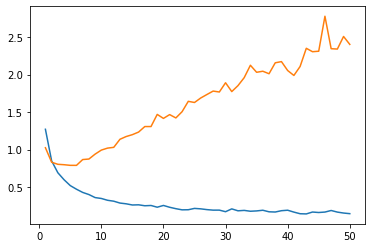

In [120]:
plost_train_test_history(train_history, test_history)

In [20]:
import torch.nn as nn 
from torch.nn import functional as F
n_hidden = 128


class LSTMModel(nn.Module):

    def __init__(self, n_letters, n_hidden, num_categories):
        super(LSTMModel, self).__init__()
        self.rnn = nn.LSTM(n_letters, n_hidden, batch_first=True,)
        self.fc = nn.Linear(n_hidden, num_categories)

    def forward(self, name):
        rnn_out, _ = self.rnn(name)
        fc_out = self.fc(rnn_out[:, -1 ]) # Only need the last output of the rnn
        return F.log_softmax(fc_out, dim=1)
        
    
model = LSTMModel(n_letters, n_hidden, dataset.num_categories)
          

In [21]:
lr=0.01

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 50

train_history, test_history = train(model, criterion, optimizer, n_epochs, train_dataloader, test_callback=test_callback)


Test loss: 1.8398
Epoch: 1/50............. Loss: 1.8651
Test loss: 1.6108
Epoch: 2/50............. Loss: 1.7766
Test loss: 1.3784
Epoch: 3/50............. Loss: 1.4572
Test loss: 1.0490
Epoch: 4/50............. Loss: 1.1631
Test loss: 0.8370
Epoch: 5/50............. Loss: 0.8820
Test loss: 0.7302
Epoch: 6/50............. Loss: 0.7149
Test loss: 0.6876
Epoch: 7/50............. Loss: 0.6123
Test loss: 0.6818
Epoch: 8/50............. Loss: 0.5458
Test loss: 0.7021
Epoch: 9/50............. Loss: 0.4881
Test loss: 0.6659
Epoch: 10/50............. Loss: 0.4511
Test loss: 0.7034
Epoch: 11/50............. Loss: 0.4065
Test loss: 0.6997
Epoch: 12/50............. Loss: 0.3717
Test loss: 0.7470
Epoch: 13/50............. Loss: 0.3362
Test loss: 0.7388
Epoch: 14/50............. Loss: 0.3137
Test loss: 0.7325
Epoch: 15/50............. Loss: 0.2824
Test loss: 0.7586
Epoch: 16/50............. Loss: 0.2704
Test loss: 0.8063
Epoch: 17/50............. Loss: 0.2357
Test loss: 0.8478
Epoch: 18/50..........

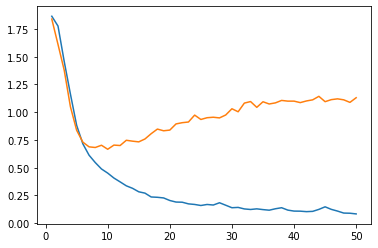

In [22]:
plost_train_test_history(train_history, test_history)